# <font face="Helvetica" size="6">Modelling Binary Lens Events </font>  

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

## <font face="Helvetica" size="5"> A brief review of binary lens microlensing </font>


Finding the magnification of a binary lens event at any point in the source's relative trajectory requires solving the lens equation for the system. The lens equation for a binary point-mass lens maps the angular position of the source to the angular image positions for a given lens configuration. It can be written in complex coordinates as,

$$z_{\mathrm{s}}=z-\frac{1}{1+q}\left(\frac{1}{\bar{z}-\bar{z}_1}+\frac{q}{\bar{z}-\bar{z}_2}\right)$$


where $z_{\mathrm{s}}$ is the position of the source in complex coordinates ($z = x + iy$), $z$ is the position of the image, $z_1$ and $z_2$ are the positions of the lens components, and $q = M_2/M_1$ is the mass ratio between the lens components. All angular positions are scaled to the angular Einstein ring radius ($\theta_E$).

The magnification of an image in this formalism is given by the inverse of the Jacobian of the mapping above evaluated at the image position,

$$\mu = \left.\frac{1}{\operatorname{det} J}\right|_{z=z_j}, \operatorname{det} J \equiv \frac{\partial\left(x_1, x_2\right)}{\partial\left(y_1, y_2\right)}$$

The magnification of images diverges when $\operatorname{det} J = 0$. The set of all image positions where this happens form closed *critical curves*, and the corresponding set of source positions define closed curves called *caustics*. Although the magnification of a point source diverges along caustic curves, that of a real-finite sized source is large but finite. 

Caustics also form boundaries of regions with different numbers of images. Microlensing of a source inside the region bound by caustics always produces two more images than when the source is outside. The topology of caustics depends on the projected separation of the lens components in units of the Einstein ring radius (s) and their mass ratio (q), and is classified into three types: *close*, *resonant/intermediate*, and *wide*.

<center><img src="./Plots/caustic_structures.png" width="1000"/></center>
<center>Fig 1: Close, resonant, and intermediate caustics for q = 0.6.</center>

For a fixed q, the boundaries of these topologies are given by, 


$$\frac{q}{(1+q)^2}=\frac{\left(1-s_c\right)^3}{27 s_c^8}, \, s_w=\frac{\left(1+q^{1 / 3}\right)^{3 / 2}}{(1+q)^{1 / 2}}$$

if $s \le s_c$ (close topology), there is one diamond-shaped caustic at the center of mass of the binary lens and two triangular caustics; if $s_c \le s \le s_w$ (resonant topology), there is one large caustic at the center of mass; and if $s \ge s_w$ (wide topology) there are two diamond-shaped caustics.

<center><img src="./Plots/caustic_topology.png" width="500"/></center>
<center>Fig 2: Boundaries of the different caustic topologies as a function of the mass ratio q of the binary lens (Gaudi, 2010).</center>

Microlensing events where the source crosses a caustic have sharp peaks in magnification on top of the smooth single lens magnification curve (as we will see in the next section) - a characteristic feature of binary lens events which can be used to easily distinguish them from single lens events. 


<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise 1</h2>
    <p>Use the interactive <i>s</i> and <i>q</i> slider to plot caustics for different lens configurations. Plot all three caustic topologies and see how caustics transition from one topology to another by changing <i>s</i>. See how caustics change with <i>q</i>, and compare caustics for a planetary mass companion and a stellar mass companion. </p>
    <br>
</div>

In [ ]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as op
import emcee
from multiprocessing import Pool
import corner
from scipy.optimize import lsq_linear
import ipywidgets as widgets
from ipywidgets import FloatSlider, FloatLogSlider
from IPython.display import display
import MulensModel as mm
import matplotlib.lines as mlines
import VBMicrolensing as vbm

In [ ]:
#Use this code to plot caustics with a slider for s and q
%matplotlib widget
# Plot limits and styling
X_MIN, X_MAX = -1.1, 1.1
Y_MIN, Y_MAX = -1.1, 1.1


def plot_binary_caustics(log_s, log_q):
    s = 10**log_s
    q = 10**log_q

    # Masses normalized so that total binary mass = 1
    m1 = 1.0 / (1.0 + q)
    m2 = q * m1

    # Lens positions (binary lens axis along the x axis with the center of mass at the origin and the more massive lens component on the left)
    z1x = -q * s / (1.0 + q)
    z2x = s / (1.0 + q)


    # Binary lens caustic and critical curves using MulensModel
    binary_caustic = mm.Caustics(s=s, q=q)
    bx, by = binary_caustic.get_caustics()
    binary_critcurves = binary_caustic.critical_curve
    bcritx, bcrity = binary_critcurves.x, binary_critcurves.y

    # Draw figure
    fig = plt.figure(figsize=(5, 5), dpi=150)
    ax = fig.add_subplot(1, 1, 1)
    plt.subplots_adjust(top=0.9, bottom=0.08, right=0.95, left=0.1, hspace=0.1, wspace=0.2)

    ax.set_xlim(X_MIN, X_MAX)
    ax.set_ylim(Y_MIN, Y_MAX)
    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    ax.set_aspect(abs((x_right - x_left) / (y_high - y_low)))

    # Plot lenses
    ax.scatter([z1x], [0.0], marker='o', s=8, color='goldenrod', label='Lens 1')
    ax.scatter([z2x], [0.0], marker='o', s=8*q, color='red', label='Lens 2')

    # Plot caustics
    ax.scatter(bx, by, marker='.', s=0.01, color='blue', alpha=0.8)
    #Plot critical curves 
    ax.scatter(bcritx, bcrity, color='gray', s = 0.01, alpha=0.5, marker='.')
    
    #Add labels for critical curves and caustics
    gray_line = mlines.Line2D([], [], color='gray', linestyle='-', label='Critical curve')
    blue_line = mlines.Line2D([], [], color='blue', linestyle='-', label='Binary caustic')
    
    #Create legend
    handles, labels = ax.get_legend_handles_labels()
    handles.append(gray_line)
    handles.append(blue_line)
    labels.append(gray_line.get_label())
    labels.append(blue_line.get_label())
    legend = ax.legend(handles, labels, loc="upper left", fontsize=9)
    ax.add_artist(legend)

    ax.set_title(f's={s:.3f}, q={q:.2e}')
    plt.show()


# Sliders
log_s = FloatSlider(value=-0.5, min=-1, max=1, step=0.05, description='Log(s)')
log_q = FloatSlider(value=-3, min=-4, max=0, step=0.1, description='Log(q)')


ui = widgets.VBox([log_s, log_q])
out = widgets.interactive_output(
    plot_binary_caustics, {"log_s": log_s, "log_q": log_q}
)

display(ui, out)


Output()

## <font face="Helvetica" size="5"> The binary lens model </font>

We need at least three additional parameters to describe a binary lens, along with the four single lens parameters ($t_0$, $u_0$, $t_E$, and $\rho$). These are:

$s$: Projected separation of the lens components in units of the Einstein ring radius $r_E$

$q$: Mass ratio between the two lens components

$\alpha$: Angle that the source trajectory makes with the binary lens axis


<center><img src="./Plots/binary_parameters.png" width="700"/></center>
<center>Fig. 3: Binary lens event parameters</center>

The plot above shows the general set up of a binary lens microlensing event, and the conventions that we will use in the rest of this notebook. The two lenses are placed on the X-axis with the more massive lens on the left. The center of mass of the system is at the origin. $\alpha$ is the angle between the vector connecting $m_1$ to $m_2$ and the source trajectory. $\tau$ is defined the same way as the single lens case, $\tau = (t - t_0)/t_E$, and is used to parameterize the trajectory.

The Einstein ring radius is defined using the combined mass of the system: $\theta_E = \sqrt{\kappa \ (m_1 + m_2) \ \pi_{rel}}$. Unlike single lens events, the Einstein ring is not a ring around which the lensed images are produced but is instead a mathematical construct used to give relative scale to the model. In a binary lens system, images form around critical curves in the image plane, which envelope the lens masses. 

Let us now see what the magnification curve for a binary lens event looks like.

<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>
<div class="exercise">
    <h2>Exercise 2</h2>
    <p>Complete the function get_mag() defined below to calculate magnifications given a binary lens model. </p>
    <br>
</div>

In [2]:
def get_mag(x0, p, t):
    '''
    Get the magnification curve for a given model and parameters.
    
    Parameters
    ----------
    x0: np.ndarray with initial parameters (t0, tE, u0, rho, s, q, alpha)
    p: list[str] with parameter names
    t: np.ndarray with data epochs
    
    Returns
    -------
    mag: np.ndarray with magnification curve
    '''
    # We will use the VBMicrolensing package to calculate magnifications for different source positions.
    VBM = vbm.VBMicrolensing()
     #create a dictionary of parameters
    params = dict(zip(p, x0))
    paramsc = params.copy()
    tau = (t - paramsc['t0']) / paramsc['tE'] 
    # Single lens model
    if len(p) < 7 :
        ul = np.sqrt(tau**2 + paramsc['u0']**2)
        if 'logrho' in paramsc.keys():
            paramsc['rho'] = 10**(paramsc['logrho'])
        mag = np.array([VBM.ESPLMag2(u, paramsc['rho']) for u in ul])
    # Binary lens model
    elif len(p) >= 7:
        ''' ------------------------------------------------------------ '''
        ''' Enter your code here to calculate source positions as a function of tau using the plot in Fig. 3 as reference. '''
        salpha = np.sin(np.radians(paramsc['alpha']))
        calpha = np.cos(np.radians(paramsc['alpha']))
        xs = -paramsc['u0'] * salpha + tau * calpha 
        ys = paramsc['u0'] * calpha + tau * salpha
        ''' ------------------------------------------------------------ '''
        if 'logs' in paramsc.keys():
            paramsc['s'] = 10**(paramsc['logs'])
        if 'logq' in paramsc.keys():
            paramsc['q'] = 10**(paramsc['logq'])
        if 'logrho' in paramsc.keys():
            paramsc['rho'] = 10**(paramsc['logrho'])
        mag = np.array([VBM.BinaryMag2(paramsc['s'], paramsc['q'], xs[i], ys[i], paramsc['rho']) for i in range(len(ys))])
    return mag

<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>
<div class="exercise">
    <h2>Exercise 3</h2>
    <p>The cell below uses this function to plot the magnification curve, caustics and source trajectory for a given binary lens model. Vary the parameters to see how the light curve changes. See what happens when the source trajectory crosses a caustic.</p>
    <br>
</div>

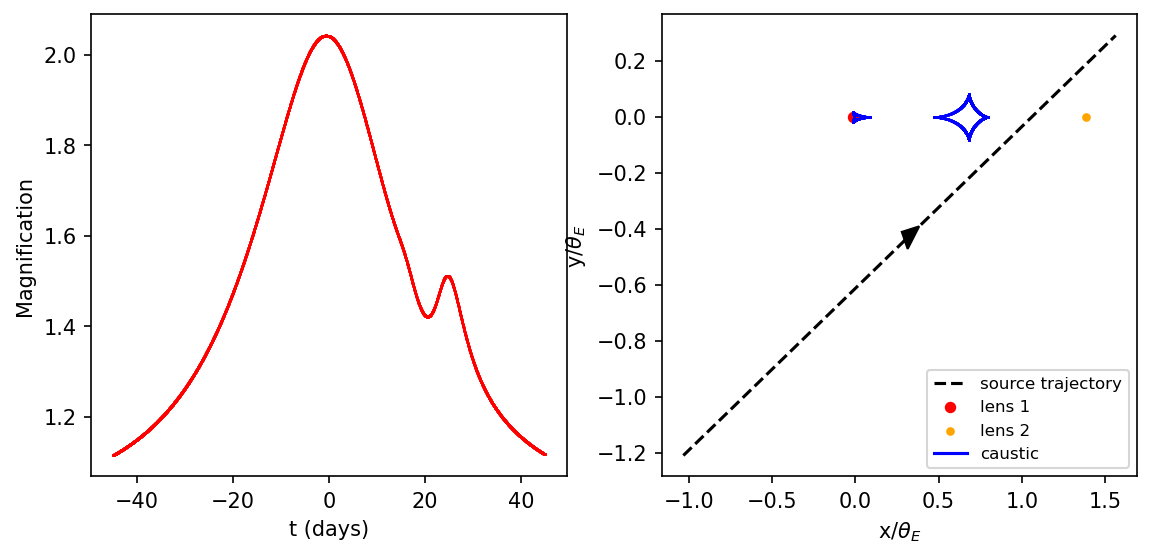

In [3]:
#Binary lens model
s = 1.4
q = 0.01
alpha = 30.0
t0 = 0.0
tE = 30.0
u0 = -0.53
rho = 0.001

#time array
t = np.linspace(t0 - 1.5*tE, t0 + 1.5*tE, 5000)
tau = (t - t0) / tE
#source positions
xs = -u0 * np.sin(np.radians(alpha)) + tau * np.cos(np.radians(alpha))
ys = u0 * np.cos(np.radians(alpha)) + tau * np.sin(np.radians(alpha))


#get caustics (using mulensmodel)
binary_caustic = mm.Caustics(s=s, q=q)
bx, by = binary_caustic.get_caustics()

#lens positions
z1x = -q * s / (1.0 + q)
z2x = s / (1.0 + q)

#magnification curve
mag = get_mag(np.array([t0, tE, u0, rho, s, q, alpha]), ['t0', 'tE', 'u0', 'rho', 's', 'q', 'alpha'], t)

#plot caustics and the light curve in two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi = 150)
ax1.scatter(t, mag, color='red', s=0.1)
ax1.set_xlabel('t (days)')
ax1.set_ylabel('Magnification')
ax2.plot(xs, ys, color='black', linestyle='--', label='source trajectory')
#add an arrow along the source trajectory
ax2.arrow(xs[len(xs)//2 + 50], ys[len(ys)//2 + 50], xs[len(xs)//2] - xs[len(xs)//2 - 10], ys[len(ys)//2] - ys[len(ys)//2 - 10], head_width=0.07, head_length=0.1, color='black')
ax2.scatter(z1x, 0.0, color='red', s=20, label='lens 1')
ax2.scatter(z2x, 0.0, color='orange', s=10, label='lens 2')
ax2.scatter(bx, by, color='blue', s=0.05)
blue_line = mlines.Line2D([], [], color='blue', linestyle='-', label='caustic')
handles, labels = ax2.get_legend_handles_labels()
handles.append(blue_line)
labels.append(blue_line.get_label())
ax2.legend(handles, labels, fontsize=8)
ax2.set_xlabel(r'x/$\theta_E$')
ax2.set_ylabel(r'y/$\theta_E$')

plt.show()

## <font face="Helvetica" size="5"> Fitting a binary lens model </font>

Now that we have the tools to create a binary lens model, let us get our hands dirty with real microlensing data and to try to fit a binary lens model to it! The cell below loads a light curve from the ground-based OGLE microlensing survey. 

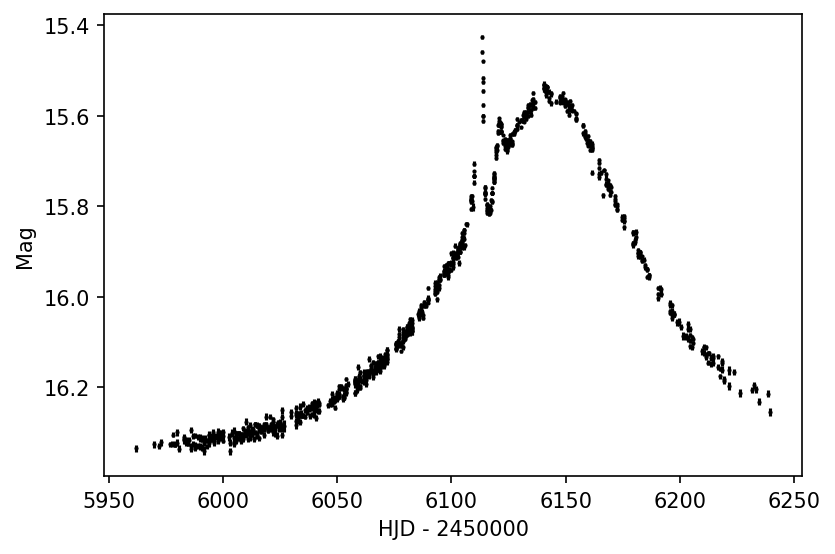

In [3]:

#Load data (row 1 is header)
df = pd.read_csv('2012-BLG-0406_data.txt', sep='\t', header=0)

#load parameters into a dictionary
params = np.loadtxt('2012-BLG-0406_params.txt', unpack=True, skiprows=1, dtype=str)
params_dict = dict(zip(params[0], np.float64(params[1])))

#select only data points where t is in range t0 - 4*tE and t0 + 3*tE
t0i = params_dict['Tmax'] - 2450000
tEi = params_dict['tau']
u0i = params_dict['umin']
df = df[(df['HJD-2450000'] > t0i - 4*tEi) & (df['HJD-2450000'] < t0i + 4*tEi)]

#Plot data
fig, ax = plt.subplots(figsize=(6, 4), dpi = 150)
ax.errorbar(df['HJD-2450000'], df['I_Mag'], yerr=df['Err'], fmt='o', color='black', label='data', markersize=1)
ax.set_xlabel('HJD - 2450000')
ax.set_ylabel('Mag')
#Invert the y-axis
ax.invert_yaxis()
plt.show()

Notice that the light curve has two additional sharp peaks in magnification, indicative of a caustic crossing event. Therefore, this event is most likely caused by a binary lens system. 

In the following cells, we will try different methods of fitting a binary lens model to this light curve. But first, we must convert the light curve to units of flux from magnitude. We will use a dummy zero point for this.

In [4]:
#Convert from magnitudes to fluxes
def mag2flux(mag: np.ndarray, 
             zp: float = 25.0
             ) -> np.ndarray:
    '''
    Converts magnitude values (array) to flux.
    
    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    f : np.ndarray
        Array of fluxes.
    '''
    f = 10.0**((mag - zp) / -2.5)
    return f

def mag2flux_err(mag: np.ndarray, mag_err: np.ndarray, 
                 zp: float = 25.0):
    '''
    Converts magnitude values and errors (array) to flux using error propagation formula.
    
    Parameters
    ----------
    mag : np.ndarray
        Array of magnitudes.
    mag_err : np.ndarray
        Array of magnitude errors.
    zp : float, optional
        Zero point of the magnitude system (default is 25.0).

    Returns
    -------
    flux_err : np.ndarray
        Array of flux errors.
    '''
    dfdmag = -0.4 * np.log(10) * 10.**(0.4*(zp-mag))
    flux_err = np.sqrt(dfdmag**2 * mag_err**2)
    return flux_err

df['I_band_flux'] = mag2flux(df['I_Mag'], 25.0)
df['I_band_flux_err'] = mag2flux_err(df['I_Mag'], df['Err'], 25.0)

So far, we have been using 7 parameters to calculate a binary lens model. But this will only give us a model magnification curve. In order to fit this to actual data, we need to convert magnifications to fluxes. The light curve of a microlensing event is given by:

$$ F = F_s A(t) + F_b $$

Where $F_s$ is the source flux and $F_b$ is the blended flux from the lens, and any other unresolved stars in the PSF of the source. Given a magnification model A, we can solve for $F_s$ and $F_b$ using linear least squares

In [5]:
def calc_Fs(modelmag: np.ndarray, f: np.ndarray, sig2: np.ndarray) -> tuple[float, float]:
    '''
    Solves for the flux parameters for a given model using least squares.
    
    Parameters
    ----------
    model : np.ndarray
        Model magnification curve.
    f : np.ndarray
        Observed flux values.
    sig2 : np.ndarray
        Flux errors.
    
    Returns
    -------
    FS : float
        Source flux.
    FB : float
        Blend flux.
    '''

    """
    Solves for FS, FB by weighted least squares with FB >= 0 using lsq_linear.
    """
    modelmag = np.asarray(modelmag, float).ravel()
    f = np.asarray(f, float).ravel()
    sig2 = np.asarray(sig2, float).ravel()

    w = 1.0 / np.sqrt(sig2)
    A = np.column_stack([modelmag, np.ones_like(modelmag)])
    Aw = A * w.reshape(-1, 1)
    bw = f * w

    res = lsq_linear(Aw, bw)
    FS, FB = res.x
    return float(FS), float(FB)

To fit a model to the light curve, we will minimize the $\chi^2$ between the data and the model

<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>
<div class="exercise">
    <h2>Exercise 4</h2>
    <p>Complete the &chi;&sup2; function in the cell below</p>
    <br>
</div>


In [6]:
def chi2(x0: np.ndarray, p: list, t: np.ndarray, f: np.ndarray, sig: np.ndarray) -> float:
    '''
    Calculates the chi squared value for a given model and parameters.
    
    Parameters
    ----------
    x0 : np.ndarray
        Initial parameters.
    p : List[str]
        List of parameter names.
    t : np.ndarray
        Data epochs.
    f : np.ndarray
        Observed flux values.
    sig : np.ndarray
        Flux errors.
    
    Returns
    -------
    chi2 : float
        Chi squared value.
    '''
    '''----------------------------------------------------------'''
    ''' Enter your code here to calculate the chi squared value '''
    mag = get_mag(x0, p, t)
    FS, FB = calc_Fs(mag, f, sig**2)
    model = FS * mag + FB
    
    chi2_value = np.sum((f - model)**2 / sig**2)
    '''----------------------------------------------------------'''
    return chi2_value

A function to perform basic downhill simplex minimization using scipy's Nelder-Mead implementation:

In [7]:
def simple_fit(df: pd.DataFrame, x0: np.ndarray, p: list[str], bounds: dict | None = None,
               fixed_params: dict | None = None, maxfev: int = 1000):
    '''
    Fit a single or binary lens model using downhill simplex method and find delta chi^2

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with data epochs, flux, and flux errors
    x0 : np.ndarray
        Initial parameters (e.g., t0, tE, u0, rho)
    p : list[str]
        Parameter names corresponding to x0
    bounds : dict | None, optional
        Optional map of parameter name -> (min, max). If None, use defaults.
    fixed_params : dict | None, optional
        Parameters to freeze as {name: value}. Only other parameters are varied.
    maxfev : int, optional
        Maximum number of function evaluations of the minimizer. Default is 1000.

    Returns
    -------
    fin_params : dict
        Dictionary with final parameters
    fin_chi2 : float
        Final chi-squared value
    delta_chi2 : float
        Delta chi-squared between best fit model and perfect model
    '''
    t = np.array(df['HJD-2450000'])
    f = np.array(df['I_band_flux'])
    sig = np.array(df['I_band_flux_err'])

    # Default bounds
    default_bounds = {
        't0': (t.min(), t.max()),
        'tE': (0.1, t.max()-t.min()),
        'u0': (-10.0, 10.0),
        'rho': (1e-5, 1.0),
        's': (1e-2, 20.0),
        'q': (1e-7, 1.0),
        'alpha': (0.0, 360.0),
        'logs': (-2, 2),
        'logq': (-7, 0),
        'logrho': (-5, 0),
    }

    # Merge user bounds with defaults
    bounds_map = default_bounds.copy()
    if bounds is not None:
        bounds_map.update({k: tuple(v) for k, v in bounds.items() if k in bounds_map})

    fixed_params = fixed_params or {}
    fixed_params = {k: float(v) for k, v in fixed_params.items()}

    # Build free/fixed split
    free_param_names = [name for name in p if name not in fixed_params]
    if len(free_param_names) == 0:
        # Nothing to optimize, just evaluate chi2 at fixed x0 values
        fin_params = dict(zip(p, x0))
        # Override with provided fixed values
        fin_params.update(fixed_params)
        x_full = np.array([fin_params[name] for name in p])
        fin_chi2 = chi2(x_full, p, t, f, sig)
        delta_chi2 = fin_chi2 - (len(f) - len(p))
        return fin_params, fin_chi2, delta_chi2

    # Initial free vector in the order of free_param_names
    x0_map = dict(zip(p, x0))
    x0_free = np.array([x0_map[name] for name in free_param_names])

    # Bounds for free parameters
    bounds_free = [bounds_map[name] for name in free_param_names]

    # Objective over free parameters that reconstructs full vector
    def objective(theta_free: np.ndarray) -> float:
        full_map = {**x0_map, **fixed_params}
        for j, name in enumerate(free_param_names):
            full_map[name] = float(theta_free[j])
        x_full = np.array([full_map[name] for name in p])
        return chi2(x_full, p, t, f, sig)

    result = op.minimize(
        objective, x0_free, bounds=bounds_free,
        method='Nelder-Mead', options={'xatol': 1e-8, 'fatol': 1e-8, 'adaptive': False, 'maxfev': maxfev}
    )

    if isinstance(result.fun, np.ndarray):
        if result.fun.ndim == 0:
            fin_chi2 = float(result.fun)
        else:
            fin_chi2 = result.fun[0]
    else:
        fin_chi2 = result.fun

    # Reconstruct final full params
    fin_map = {**x0_map, **fixed_params}
    for j, name in enumerate(free_param_names):
        fin_map[name] = float(result.x[j])

    fin_params = {name: fin_map[name] for name in p}
    dof_params = len(free_param_names)
    delta_chi2 = fin_chi2 - (len(f) - dof_params)

    return fin_params, fin_chi2, delta_chi2

Let us use this function to first fit a single lens model to the light curve. Although this particular light curve is very obviously not a single lens event, this can give us a decent first guess/ estimate of the single lens parameters for the event ($t_0$, $u_0$, $t_E$, $\rho$). We can eyeball the initial guesses for $t_0$ and $t_E$ from the light curve and get pretty close to the right answer, and refine the initial guess in successive iterations.  

Final parameters:  {'t0': 6141.666273286418, 'tE': 54.27628966915435, 'u0': 0.6899691409882683, 'rho': 0.0009681427204332366}
Reduced chi2:  48.630391910432245
Delta chi2:  45248.87231491063
Source flux:  4465.420810207076 Blend flux:  -1575.3058579068372


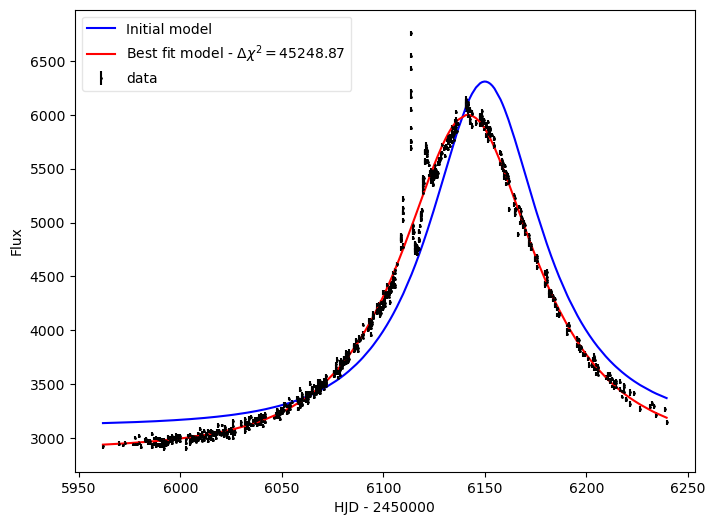

In [8]:
#Enter your initial guesses for the parameters
t0i = 6150
u0i = 0.6
tEi = 50
rhoi = 0.001
x0 = np.array([t0i, tEi, u0i, rhoi])
p = ['t0', 'tE', 'u0', 'rho']
t = np.array(df['HJD-2450000'])
init_modelmag = get_mag(x0, p, t)
source_flux, blend_flux = calc_Fs(init_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
init_model = source_flux * init_modelmag + blend_flux

fin_params, fin_chi2, delta_chi2 = simple_fit(df, x0, p)
x = np.array([fin_params['t0'], fin_params['tE'], fin_params['u0'], fin_params['rho']])
print("Final parameters: ", fin_params)
print("Reduced chi2: ", fin_chi2/(len(df)-len(p)))
print("Delta chi2: ", delta_chi2)
fin_modelmag = get_mag(x, p, df['HJD-2450000'])
source_flux, blend_flux = calc_Fs(fin_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
print("Source flux: ", source_flux, "Blend flux: ", blend_flux)
final_model = source_flux * fin_modelmag + blend_flux

#plot the data and the model
fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(df['HJD-2450000'], df['I_band_flux'], yerr=df['I_band_flux_err'], fmt='o', color='black', label='data', markersize=1)
plt.plot(df['HJD-2450000'], init_model, color='blue', label='Initial model')
plt.plot(df['HJD-2450000'], final_model, color='red', label=f'Best fit model - $\Delta \chi^2 = {delta_chi2:.2f}$')
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.legend(loc='upper left', framealpha=0.5)
plt.show()
    

    

Great! The final model looks like a fairly good fit to the light curve minus the perturbation due to the lens companion. Notice that the blend flux has turned out to be negative which is unphysical and hence this cannot be a valid model for this light curve. Now let us try to fit a binary lens model using the same function, from random initial guesses for the additional binary parameters.

Final parameters:  {'t0': 6140.739272070368, 'tE': 101.12520316084381, 'u0': 0.29350600572721985, 'rho': 3.889931330855737e-05, 'logs': 0.06636264569943334, 'logq': -2.9301870738318585, 'alpha': 226.9910840489789, 's': 1.165098506896648, 'q': 0.0011743915727882644}
Reduced chi2:  19.481348165124544
Delta chi2:  17501.836712372944
Source flux:  -27059089.711358465 
Blend flux:  27077876.897566807


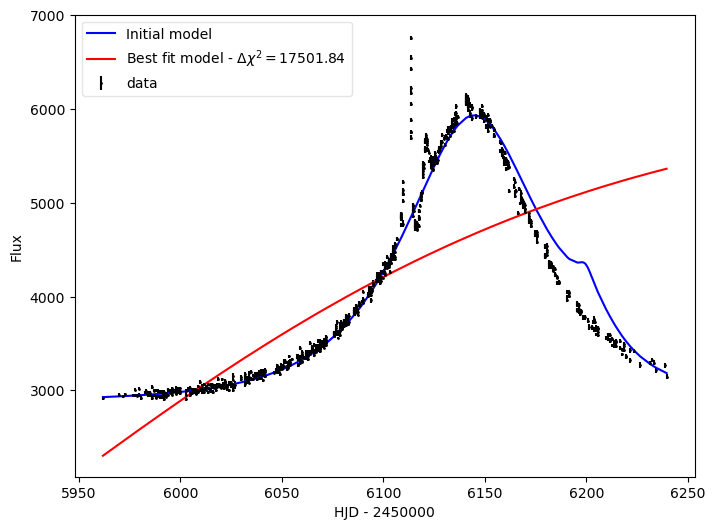

In [9]:
#Start from best fit single lens parameters
t0i = 6141.66
tEi = 54.27
u0i = 0.6899
rhoi = 0.00096
#And random guesses for the binary parameters
logsi = np.random.uniform(-2, 1)
logqi = np.random.uniform(-5, 0)
alphai = np.random.uniform(0.0, 360.0)

x0 = np.array([t0i, tEi, u0i, rhoi, logsi, logqi, alphai])
p = ['t0', 'tE', 'u0', 'rho', 'logs', 'logq', 'alpha']
init_modelmag = get_mag(x0, p, t)
source_flux, blend_flux = calc_Fs(init_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
init_model = source_flux * init_modelmag + blend_flux

fin_params, fin_chi2, delta_chi2 = simple_fit(df, x0, p, maxfev=1000)
fin_params['s'] = 10**(fin_params['logs'])
fin_params['q'] = 10**(fin_params['logq'])
x = np.array([fin_params['t0'], fin_params['tE'], fin_params['u0'], fin_params['rho'], fin_params['s'], fin_params['q'], fin_params['alpha']])
print("Final parameters: ", fin_params)
print("Reduced chi2: ", fin_chi2/(len(df)-len(p)))
print("Delta chi2: ", delta_chi2)
fin_modelmag = get_mag(x, p, t)
source_flux, blend_flux = calc_Fs(fin_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
final_model = source_flux * fin_modelmag + blend_flux
print("Source flux: ", source_flux, "\nBlend flux: ", blend_flux)

#plot the data and the model
fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(df['HJD-2450000'], df['I_band_flux'], yerr=df['I_band_flux_err'], fmt='o', color='black', label='data', markersize=1)
plt.plot(df['HJD-2450000'], init_model, color='blue', label='Initial model')
plt.plot(df['HJD-2450000'], final_model, color='red', label=f'Best fit model - $\Delta \chi^2 = {delta_chi2:.2f}$')
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.legend(loc='upper left', framealpha=0.5)
plt.show()

This was a disaster! A binary lens microlensing model is too complex to be fit by a simple gradient descent-like algorithm. The likelihood (or $\chi^2$) space of a binary lens event is very rugged and riddled with deep local minima. So any gradient descent method will fail or get stuck in a local minimum unless we are very close to the true solution.

But we don't have to start from a completely random guess for the binary lens parameters. The shape and poistion of the planetary/stellar companion perturbation can be used to get a rough estimate of the binary parameters following the procedure outlined in [Gaudi & Gould (1997)](https://ui.adsabs.harvard.edu/abs/1997ApJ...486..675G). This is further elaborated in [Analytic planet parameters notebook](./Day4_Gould_Loeb_planetary_event.ipynb) and the [Microlensing Source](https://www.microlensing-source.org/concept/extracting-parameters/) website.

Let us try to fit the model from a better guess for the binary parameters

Final parameters:  {'t0': 6140.5295007931345, 'tE': 75.96786416586343, 'u0': 0.43405193420551647, 'logrho': -1.722934263364147, 'logs': 0.14740137680073662, 'logq': -2.445914746022167, 'alpha': 228.94846208681884, 's': 1.404110790226617, 'q': 0.0035816673995861083, 'rho': 0.018926300733976838}
Reduced chi2:  23.865075971853173
Delta chi2:  21653.226945344955
Source flux:  2263.815545252644 
Blend flux:  547.1845955263436


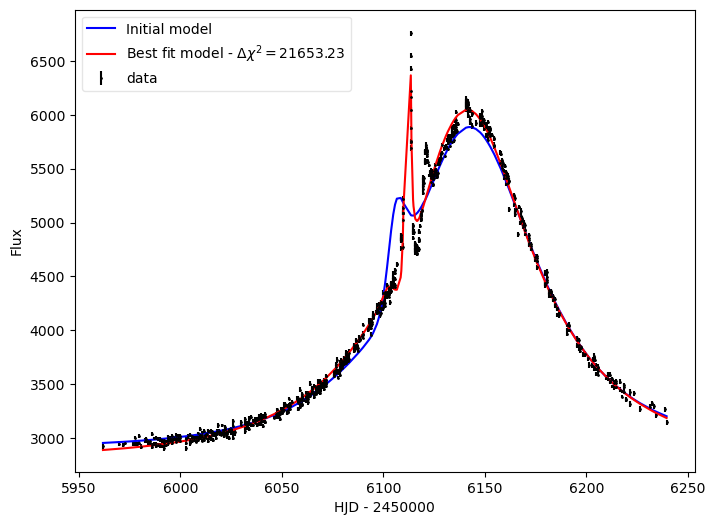

In [10]:
logrhoi = -1.344
logsi = 0.257
logqi = -2.211
alphai = 180 + np.degrees(0.829)

x0 = np.array([t0i, tEi, u0i, logrhoi, logsi, logqi, alphai])
p = ['t0', 'tE', 'u0', 'logrho', 'logs', 'logq', 'alpha']
init_modelmag = get_mag(x0, p, t)
source_flux, blend_flux = calc_Fs(init_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
init_model = source_flux * init_modelmag + blend_flux

fin_params, fin_chi2, delta_chi2 = simple_fit(df, x0, p)
fin_params['s'] = 10**(fin_params['logs'])
fin_params['q'] = 10**(fin_params['logq'])
fin_params['rho'] = 10**(fin_params['logrho'])
x = np.array([fin_params['t0'], fin_params['tE'], fin_params['u0'], fin_params['logrho'], fin_params['logs'], fin_params['logq'], fin_params['alpha']])
print("Final parameters: ", fin_params)
print("Reduced chi2: ", fin_chi2/(len(df)-len(p)))
print("Delta chi2: ", delta_chi2)
fin_modelmag = get_mag(x, p, t)
source_flux, blend_flux = calc_Fs(fin_modelmag, df['I_band_flux'], df['I_band_flux_err']**2)
final_model = source_flux * fin_modelmag + blend_flux
print("Source flux: ", source_flux, "\nBlend flux: ", blend_flux)
#plot the data and the model
fig, ax = plt.subplots(figsize=(8, 6))
plt.errorbar(df['HJD-2450000'], df['I_band_flux'], yerr=df['I_band_flux_err'], fmt='o', color='black', label='data', markersize=1)
plt.plot(df['HJD-2450000'], init_model, color='blue', label='Initial model')
plt.plot(df['HJD-2450000'], final_model, color='red', label=f'Best fit model - $\Delta \chi^2 = {delta_chi2:.2f}$')
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.legend(loc='upper left', framealpha=0.5)
plt.show()

Although this is a better fit, the initial condition is still not close enough to the true solution for this method to work. 

A better way to search the likelihood space is by using Markov Chain Monte Carlo (MCMC). The stochastic nature of this algorithm allows it to escape local minima where a gradient descent algorithm would get stuck. 

In the cells below we will implement the MCMC algorithm to fit a binary lens model and find posterior distributions for all parameters. We have defined a posterior probability function by using the $\chi^2$ likelihood for a model, and flat priors as long as the parameters are within user-defined bounds. 

The [emcee](https://emcee.readthedocs.io/en/stable/) package is used to run the MCMC algorithm. It is called by a custom MCMC class for microlensing modelling that calculates various convergence staistics, determines burn-in period, finds the MLE solution and confidence intervals, and plots a corner plot of posteriors as well as chains for all walkers. 

In [11]:
# Define the log prior function - used to set bounds on parameters
def log_prior(x0, p, t, bounds: dict | None = None):
    ''' bounds on parameters
    
    Parameters
    ----------
    x0 : np.ndarray
        Parameter vector (e.g., t0, tE, u0, rho, ...)
    p : list[str]
        Corresponding parameter names
    t : np.ndarray
        Data epochs
    bounds : dict | None, optional
        Optional map of parameter name -> (min, max). If None, use defaults.
    '''

    default_bounds = {'t0': (t.min(), t.max()), 'tE': (0.1, t.max()-t.min()), 'u0': (-10.0, 10.0), 'rho': (1e-5, 1.0), 's': (1e-2, 20.0), 'q': (1e-7, 1.0), 'alpha': (0.0, 360.0), 'logs': (-2, 2), 'logq': (-7, 0), 'logrho': (-5, 0)}
    bounds_map = default_bounds.copy()
    if bounds is not None:
        bounds_map.update({k: tuple(v) for k, v in bounds.items() if k in bounds_map})

    for index, key in enumerate(p):
        lower, upper = bounds_map[key]
        if x0[index] < lower or x0[index] > upper:
            return -np.inf
    return 0.
#Calculate the log likelihood using the chi2 function
def log_likelihood(x0, p, t, f, sig):
    '''calculating chi2'''
    ll = -1./2. * chi2(x0, p, t, f, sig)
    return ll
#Return the log probability by adding the log prior and log likelihood
def log_probability(x0, p, t, f, sig, bounds: dict | None = None):
    lp = log_prior(x0, p, t, bounds=bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(x0, p, t, f, sig)



You must install the tqdm library to use progress indicators with emcee



Maximum Likelihood Estimate (MLE) parameters (full):
t0: 6142.433161
tE: 56.773075
u0: 0.551931
logrho: -2.998939
logs: 0.138675
logq: -2.155708
alpha: 226.334001

Median values with 1σ uncertainties (free params only):
t0: 6141.989343 +0.178674 -0.635168
tE: 55.876023 +2.806913 -6.040449
u0: 0.570581 +0.115949 -0.024066
logrho: -2.432395 +1.229474 -2.468706
logs: 0.198922 +0.203048 -0.060353
logq: -2.183923 +0.058726 -0.553233
alpha: 226.443385 +2.987734 -0.330721

MLE Chi-squared: 9860.43
MLE Reduced chi-squared: 10.41
MLE Delta chi-squared: 8913.43

CONVERGENCE SUMMARY
⚠ POTENTIAL CONVERGENCE ISSUES:
  • Low acceptance fraction
  • 7 parameters have R-hat > 1.1
  • Low effective sample sizes

💡 RECOMMENDATIONS:
  - Consider decreasing step size in proposal distribution
  - Run longer chains for better mixing
  - Run longer chains to increase effective sample size

📊 SUMMARY:
  • Total steps: 1000
  • Burn-in: 300 steps
  • Effective samples: 35000
  • Acceptance rate: 0.135
  • Min

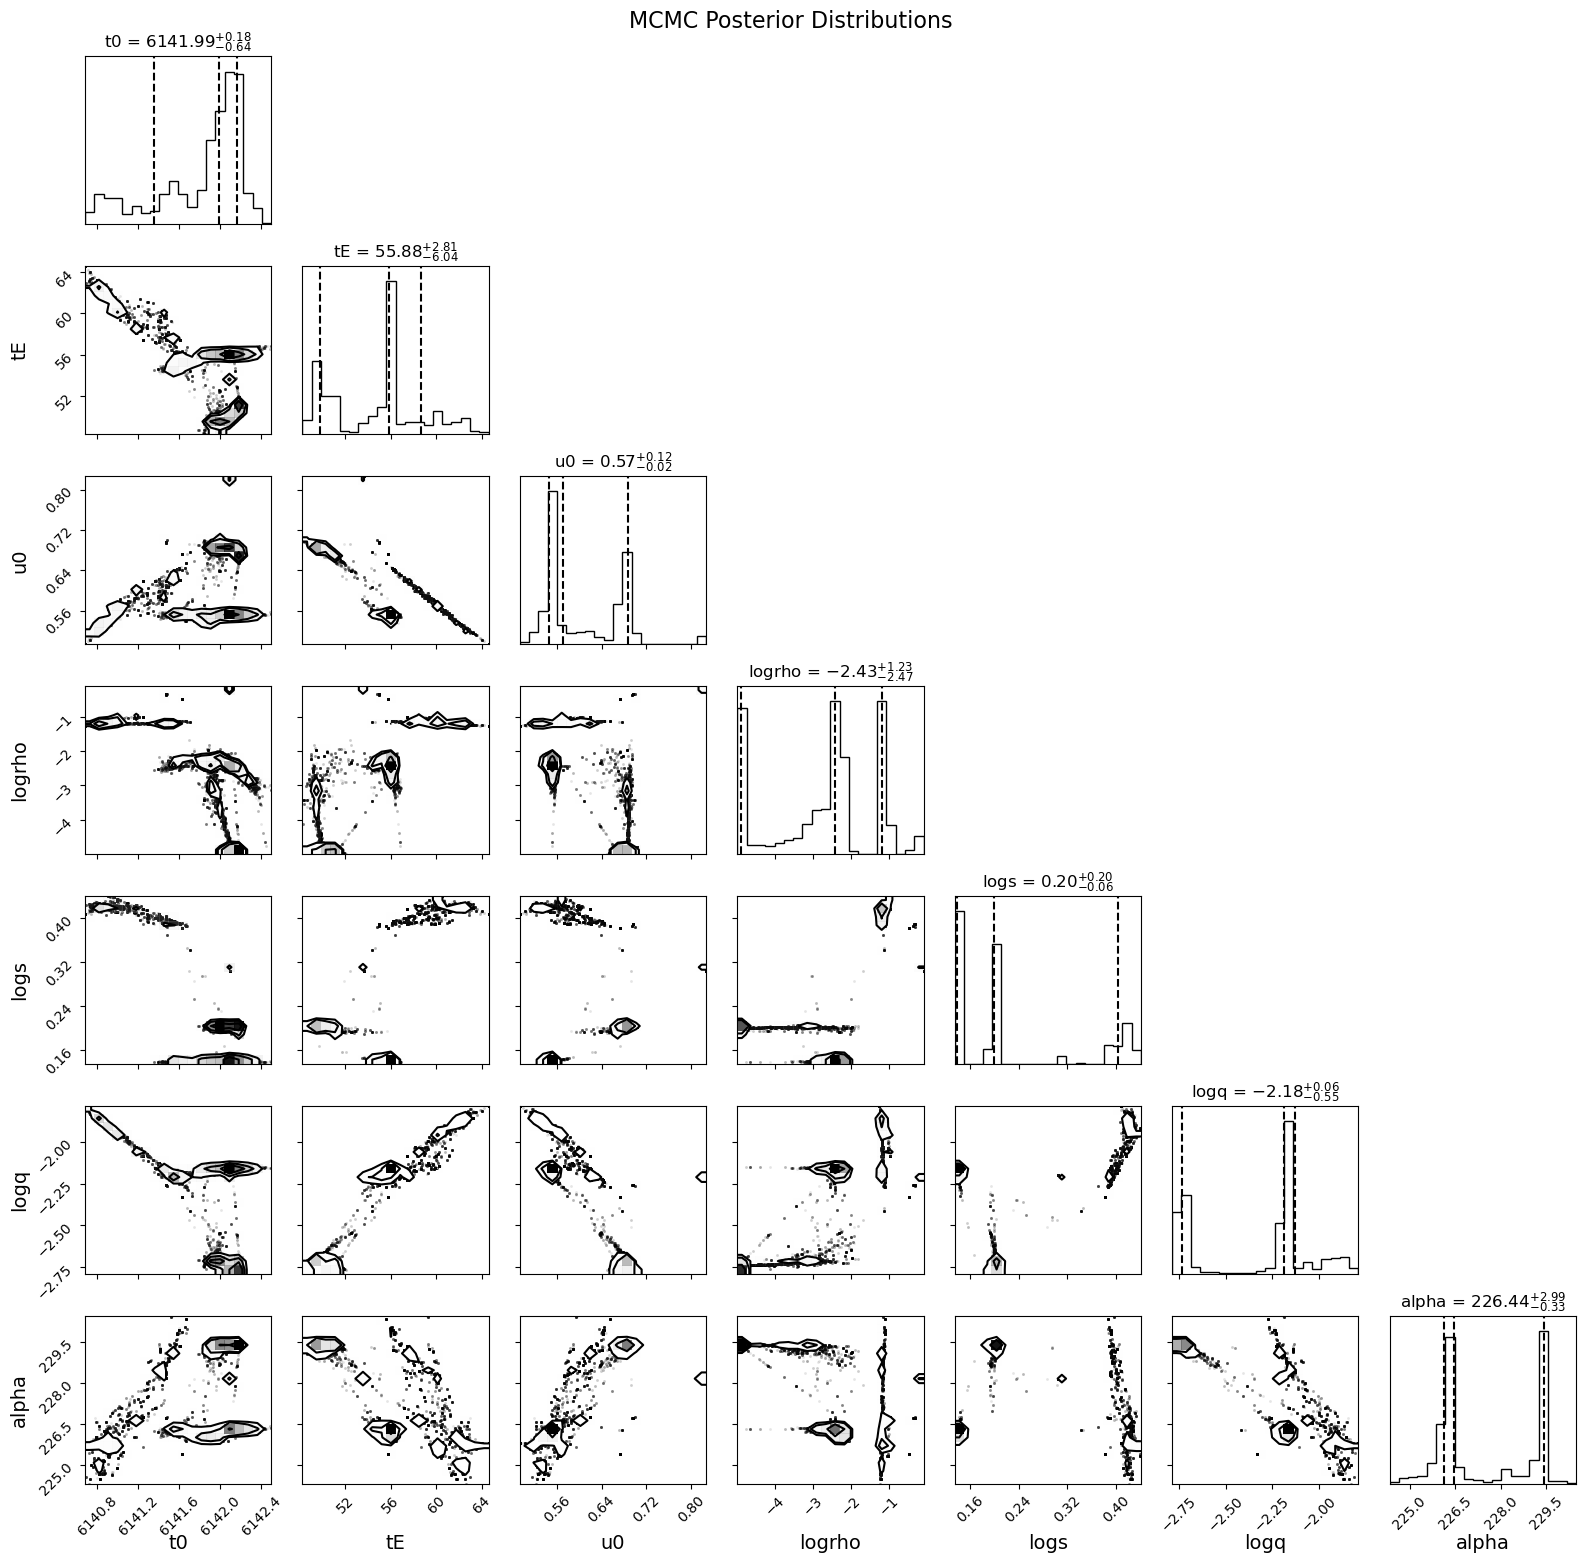

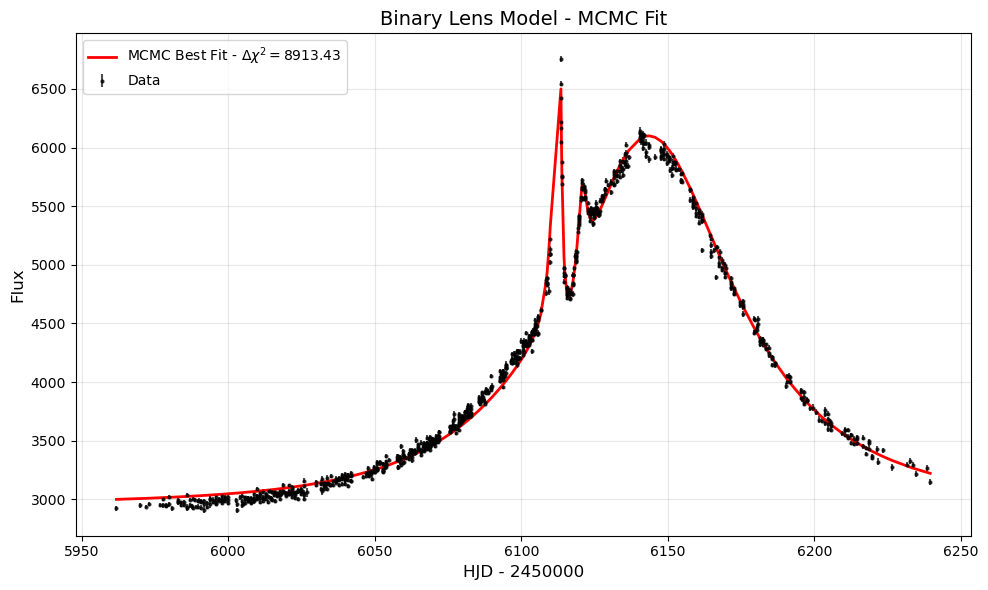

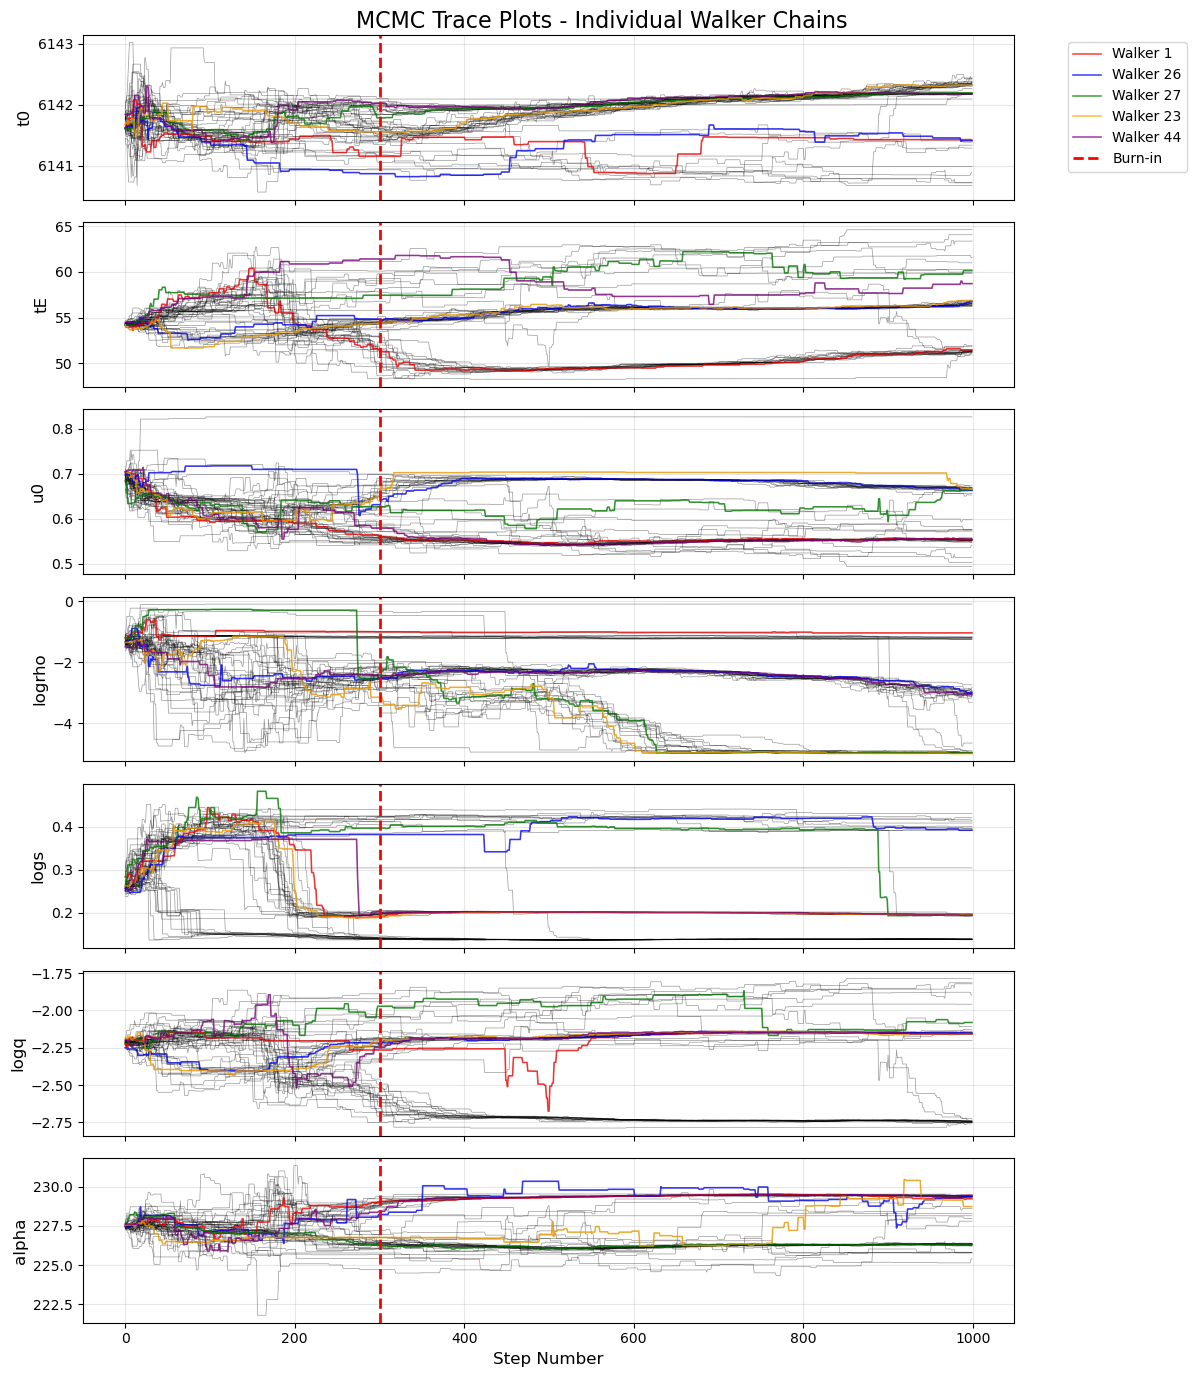

In [12]:
from microlens_emcee import micro_mc
# Set random seed for reproducibility 
np.random.seed(46)

# Set up initial parameters for binary lens model
logrhoi = -1.344
logsi = 0.257
logqi = -2.211
alphai = 180 + np.degrees(0.829)

x0 = np.array([t0i, tEi, u0i, logrhoi, logsi, logqi, alphai])
p = ['t0', 'tE', 'u0', 'logrho', 'logs', 'logq', 'alpha']

#Apply more stringent bounds on single lens parameters since we have a fairly good guess of what they are
informed_guess_mcmc = micro_mc(df, x0, p, log_probability, bounds={'t0': (t0i - tEi, t0i + tEi), 'tE': (tEi - 20, tEi + 20), 'u0': (u0i - 0.2, u0i + 0.2)})

#Run MCMC analysis with all plots enabled
results = informed_guess_mcmc.perform_mcmc_analysis(steps=1000, walkers=50, param_scales=np.array([1e-1, 1e-1, 1e-2, 1e-1, 1e-2, 1e-2, 1e-1]),
                               verbose=False, plot_corner=True, plot_fit=True, 
                               plot_traces=True, plot_convergence=False)

Although the MLE solution looks like it is pretty close to the right answer, the posterior distributions for this run are all over the place! The walker chains of all parameters are split multiple times indicating that they are getting stuck in local minima and are not able to fully explore the parameter space. 

The best way to explore the phase space of all possible solutions is to do a **grid search**. This is the method used to analyze all individual planetary microlensing events so far. The idea of a grid search is to search for the best starting guesses on a large grid of binary parameters ($s$, $q$, and $\alpha$). The best *n* solutions are picked from the results of this search and a glabal minimum search is conducted using MCMC starting from these parameters. This is the most robust method to ensure that we find the global minimum, although it is also very computationally expensive. The other advantage of this method is its ability to identify ***degenerate solutions***. Microlensing models have several degeneracies, some of which can be broken by the measurement of higher order effects or better light curve sampling, but some which are inherent and cannot be resolved by just observing the light curve. We will discuss degeneracies in greater detail in the following section. 

There are many different prescriptions for a grid search that researchers have used in the past. They differ in the parameters used to create the grid, the minimation routines used, the method used to calculate magnifications, and the procedure followed to identify the global minimum once the grid search is completed. In the following cells we demonstrate a very simple grid search algorithm on a coarse grid of ($s$, $q$, $\alpha$). For each grid point, we find the best fit values of the single lens parameters ($t_0$, $t_E$, $u_0$, $\rho$) by fitting a binary lens model using the simple_fit function. During the fitting, we only vary the single lens parameters and keep ($s$, $q$, $\alpha$) fixed. For each ($s$, $q$) we then pick the $\alpha$ value which produces the smallest $\chi^2$ and store the $\alpha$ and $\chi^2$. From this final grid of ($s$, $q$) we can choose the best *n* grid points that produce the smallest $\chi^2$ and run MCMC minimizations starting from those parameters. For the MCMC runs, all parameters are varied. 

In [ ]:
def grid_search_binary(df, logs_vals, logq_vals, alpha_vals, 
                       t0_init, u0_init, tE_init, logrho_init,
                       bounds=None, verbose=False):
    """
    Perform grid search over binary lens parameters (logs, logq, alpha).
    
    For each (logs, logq) point on the grid, this function:
    1. Loops through all alpha values
    2. Optimizes t0, u0, tE, logrho using simple_fit with fixed binary params
    3. Selects the alpha value that gives the minimum delta_chi2
    4. Stores the best result for that (logs, logq) point
    
    Parameters
    ----------
    df : pd.DataFrame
        Data with 'HJD-2450000', 'I_band_flux', 'I_band_flux_err'
    logs_vals : array-like
        Grid values for log10(s)
    logq_vals : array-like  
        Grid values for log10(q)
    alpha_vals : array-like
        Grid values for alpha (degrees)
    t0_init, u0_init, tE_init, logrho_init : float
        Initial values for optimization at each grid point
    bounds : dict, optional
        Parameter bounds for simple_fit
    verbose : bool, optional
        Print progress information
    
    Returns
    -------
    results : dict
        Contains:
        - 'logs_vals': 1D array of logs values
        - 'logq_vals': 1D array of logq values  
        - 'delta_chi2_grid': 2D array of minimum delta_chi2 for each (logs,logq)
        - 'best_alpha_grid': 2D array of best alpha for each (logs,logq)
        - 'best_params_grid': 2D array of dicts with all best-fit params
        - 'sorted_results': List of dicts sorted by delta_chi2 (ascending)
        - 'fig': matplotlib figure with visualization
    """
    
    # Initialize storage arrays
    delta_chi2_grid = np.zeros((len(logq_vals), len(logs_vals)))
    best_alpha_grid = np.zeros((len(logq_vals), len(logs_vals)))
    best_params_grid = np.empty((len(logq_vals), len(logs_vals)), dtype=object)
    
    # Calculate total number of grid points
    total_points = len(logs_vals) * len(logq_vals)
    
    if verbose:
        print(f"Processing {total_points} grid points...")
    
    # Loop through each (logs, logq) grid point
    completed = 0
    for i, logs_val in enumerate(logs_vals):
        for j, logq_val in enumerate(logq_vals):
            # For this (logs, logq) point, find best alpha
            min_delta_chi2 = np.inf
            best_alpha = None
            best_params = None
            
            for alpha_val in alpha_vals:
                x0 = np.array([t0_init, tE_init, u0_init, logrho_init, 
                              logs_val, logq_val, alpha_val])
                p = ['t0', 'tE', 'u0', 'logrho', 'logs', 'logq', 'alpha']
                
                fixed_params = {'logs': logs_val, 'logq': logq_val, 
                               'alpha': alpha_val}
                
                fin_params, fin_chi2, delta_chi2 = simple_fit(
                    df, x0, p, bounds=bounds, fixed_params=fixed_params)
                
                if delta_chi2 < min_delta_chi2:
                    min_delta_chi2 = delta_chi2
                    best_alpha = alpha_val
                    best_params = fin_params
            
            # Store results for this grid point
            delta_chi2_grid[j, i] = min_delta_chi2
            best_alpha_grid[j, i] = best_alpha
            best_params_grid[j, i] = best_params
            
            completed += 1
            if verbose and completed % 10 == 0:
                print(f"Completed {completed}/{total_points} grid points")
    
    if verbose:
        print(f"Grid search complete! Processed {total_points} points.")
    
    # Create meshgrids for plotting
    logs_grid, logq_grid = np.meshgrid(logs_vals, logq_vals)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Use pcolormesh for 2D grid visualization
    im = ax.pcolormesh(logs_grid, logq_grid, np.log10(delta_chi2_grid),
                       cmap='viridis', shading='auto')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('$log_{10}(\\Delta \\chi^2)$', fontsize=14)
    
    ax.set_xlabel('log10(s)', fontsize=14)
    ax.set_ylabel('log10(q)', fontsize=14)
    ax.set_title('Grid Search: Binary Lens Parameters', fontsize=16)
    
    # Mark the global minimum
    min_idx = np.unravel_index(np.argmin(delta_chi2_grid), 
                               delta_chi2_grid.shape)
    ax.plot(logs_grid[min_idx], logq_grid[min_idx], 
            'r*', markersize=20, label='Global minimum')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create sorted list of all results
    sorted_results = []
    for i in range(len(logs_vals)):
        for j in range(len(logq_vals)):
            sorted_results.append({
                'logs': logs_vals[i],
                'logq': logq_vals[j],
                's': 10**logs_vals[i],
                'q': 10**logq_vals[j],
                'best_alpha': best_alpha_grid[j, i],
                'delta_chi2': delta_chi2_grid[j, i],
                'all_params': best_params_grid[j, i]
            })
    
    # Sort by delta_chi2 (ascending)
    sorted_results = sorted(sorted_results, key=lambda x: x['delta_chi2'])
    
    return {
        'logs_vals': logs_vals,
        'logq_vals': logq_vals,
        'delta_chi2_grid': delta_chi2_grid,
        'best_alpha_grid': best_alpha_grid,
        'best_params_grid': best_params_grid,
        'sorted_results': sorted_results,
        'fig': fig
    }

Processing 100 grid points sequentially...
Completed 10/100 grid points
Completed 20/100 grid points
Completed 30/100 grid points
Completed 40/100 grid points
Completed 50/100 grid points
Completed 60/100 grid points
Completed 70/100 grid points
Completed 80/100 grid points
Completed 90/100 grid points
Completed 100/100 grid points
Grid search complete! Processed 100 points.


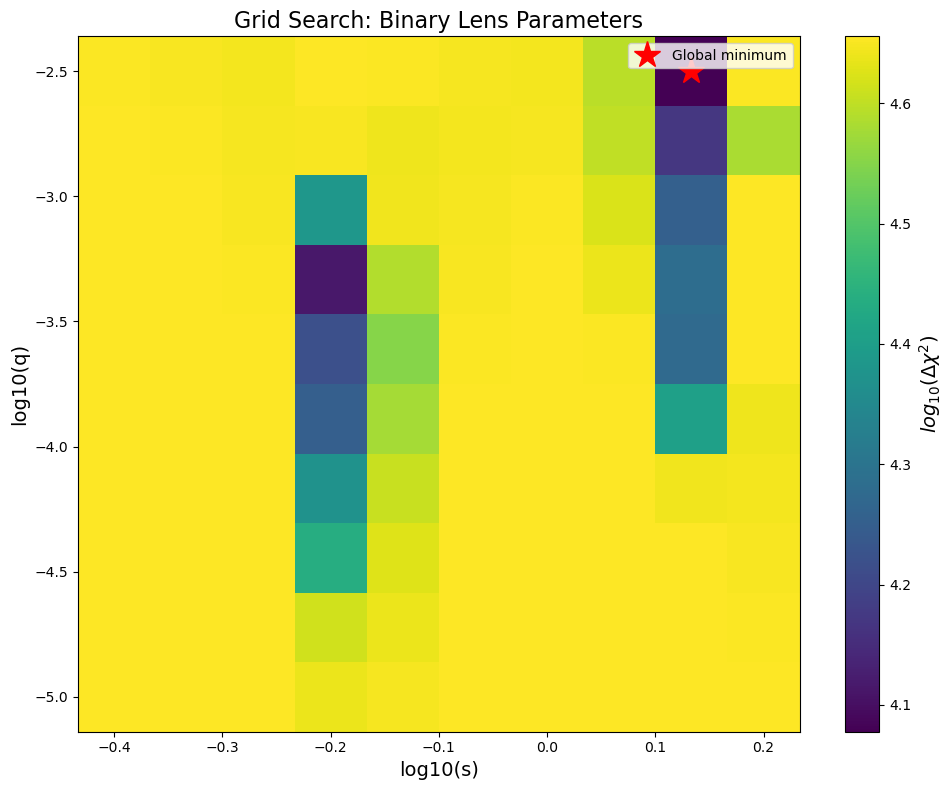


GRID SEARCH RESULTS

Global minimum delta_chi2: 11960.50

Top 5 Best Solutions (sorted by delta_chi2):
------------------------------------------------------------

Rank 1:
  logs = 0.133  (s = 1.359)
  logq = -2.500  (q = 0.003162)
  alpha = 227.4 deg
  delta_chi2 = 11960.50
  All params: {'t0': 6141.8793396291985, 'tE': 60.20932709668017, 'u0': 0.5332275542932001, 'logrho': -1.8229973179236934, 'logs': 0.13333333333333341, 'logq': -2.5, 'alpha': 227.36842105263156}

Rank 2:
  logs = -0.200  (s = 0.631)
  logq = -3.333  (q = 0.000464)
  alpha = 56.8 deg
  delta_chi2 = 13052.43
  All params: {'t0': 6141.503804782757, 'tE': 50.364734782131464, 'u0': 0.7553130449919341, 'logrho': -2.5409893361883023, 'logs': -0.19999999999999998, 'logq': -3.333333333333333, 'alpha': 56.84210526315789}

Rank 3:
  logs = 0.133  (s = 1.359)
  logq = -2.778  (q = 0.001668)
  alpha = 227.4 deg
  delta_chi2 = 14757.43
  All params: {'t0': 6141.862726401334, 'tE': 61.476162259681615, 'u0': 0.5259671388479465, 

In [ ]:
#Run the grid search. Takes about ~ 40 mins to run on a Macbook Pro

# Define grid ranges
logs_vals = np.linspace(-0.4, 0.2, 10)  
logq_vals = np.linspace(-5, -2.5, 10)  
alpha_vals = np.linspace(0, 360, 20)  

# Initial values for optimization (from best fit single lens model)
t0_init = t0i
u0_init = u0i
tE_init = tEi
logrho_init = np.log10(rhoi)

# Run grid search (sequential execution for notebook compatibility)
results = grid_search_binary(
    df, logs_vals, logq_vals, alpha_vals,
    t0_init, u0_init, tE_init, logrho_init, 
    bounds={'u0': (u0i - 2, u0i + 2), 'logrho': (-6, -0.5), 't0': (t0i - tEi, t0i + tEi), 'tE': (tEi - 20, tEi + 20)},
    verbose=True
)

# Access the best results
print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"\nGlobal minimum delta_chi2: {np.min(results['delta_chi2_grid']):.2f}")

# Top 5 best solutions
print("\nTop 5 Best Solutions (sorted by delta_chi2):")
print("-" * 60)
for i, res in enumerate(results['sorted_results'][:5]):
    print(f"\nRank {i+1}:")
    print(f"  logs = {res['logs']:.3f}  (s = {res['s']:.3f})")
    print(f"  logq = {res['logq']:.3f}  (q = {res['q']:.6f})")
    print(f"  alpha = {res['best_alpha']:.1f} deg")
    print(f"  delta_chi2 = {res['delta_chi2']:.2f}")
    print(f"  All params: {res['all_params']}")

# Access the global best solution
best = results['sorted_results'][0]
print("\n" + "="*60)
print("BEST FIT PARAMETERS")
print("="*60)
print(f"s = {best['s']:.4f}")
print(f"q = {best['q']:.6f}")
print(f"alpha = {best['best_alpha']:.2f} degrees")
print(f"t0 = {best['all_params']['t0']:.6f}")
print(f"tE = {best['all_params']['tE']:.6f}")
print(f"u0 = {best['all_params']['u0']:.6f}")
print(f"rho = {10**best['all_params']['logrho']:.6f}")
print(f"Delta chi2 = {best['delta_chi2']:.2f}")


The grid search gave us two regions of the grid with good fits to the light curve. We can now start an MCMC run from any of these initial parameters. Though in reality, we would first want to create finer grids in the regions with small $\chi^2$ values to get better starting points for the MCMC runs. 

Let us try to fit the event starting from the global minimum solution on this grid:


Maximum Likelihood Estimate (MLE) parameters (full):
t0: 6141.411975
tE: 62.876715
u0: 0.538289
logrho: -2.007473
logs: 0.129855
logq: -2.242950
alpha: 229.641439

Median values with 1σ uncertainties (free params only):
t0: 6141.419115 +0.031630 -0.025258
tE: 62.833910 +0.108917 -0.137746
u0: 0.538144 +0.001256 -0.001179
logrho: -2.007804 +0.007260 -0.007390
logs: 0.129865 +0.000326 -0.000263
logq: -2.243393 +0.002816 -0.003381
alpha: 229.608150 +0.057898 -0.068950

MLE Chi-squared: 3923.46
MLE Reduced chi-squared: 4.14
MLE Delta chi-squared: 2976.46

CONVERGENCE SUMMARY
⚠ POTENTIAL CONVERGENCE ISSUES:
  • 7 parameters have R-hat > 1.1
  • Low effective sample sizes

💡 RECOMMENDATIONS:
  - Run longer chains for better mixing
  - Run longer chains to increase effective sample size

📊 SUMMARY:
  • Total steps: 1000
  • Burn-in: 300 steps
  • Effective samples: 70000
  • Acceptance rate: 0.392
  • Min effective size: 72
  • Max R-hat: 30.582



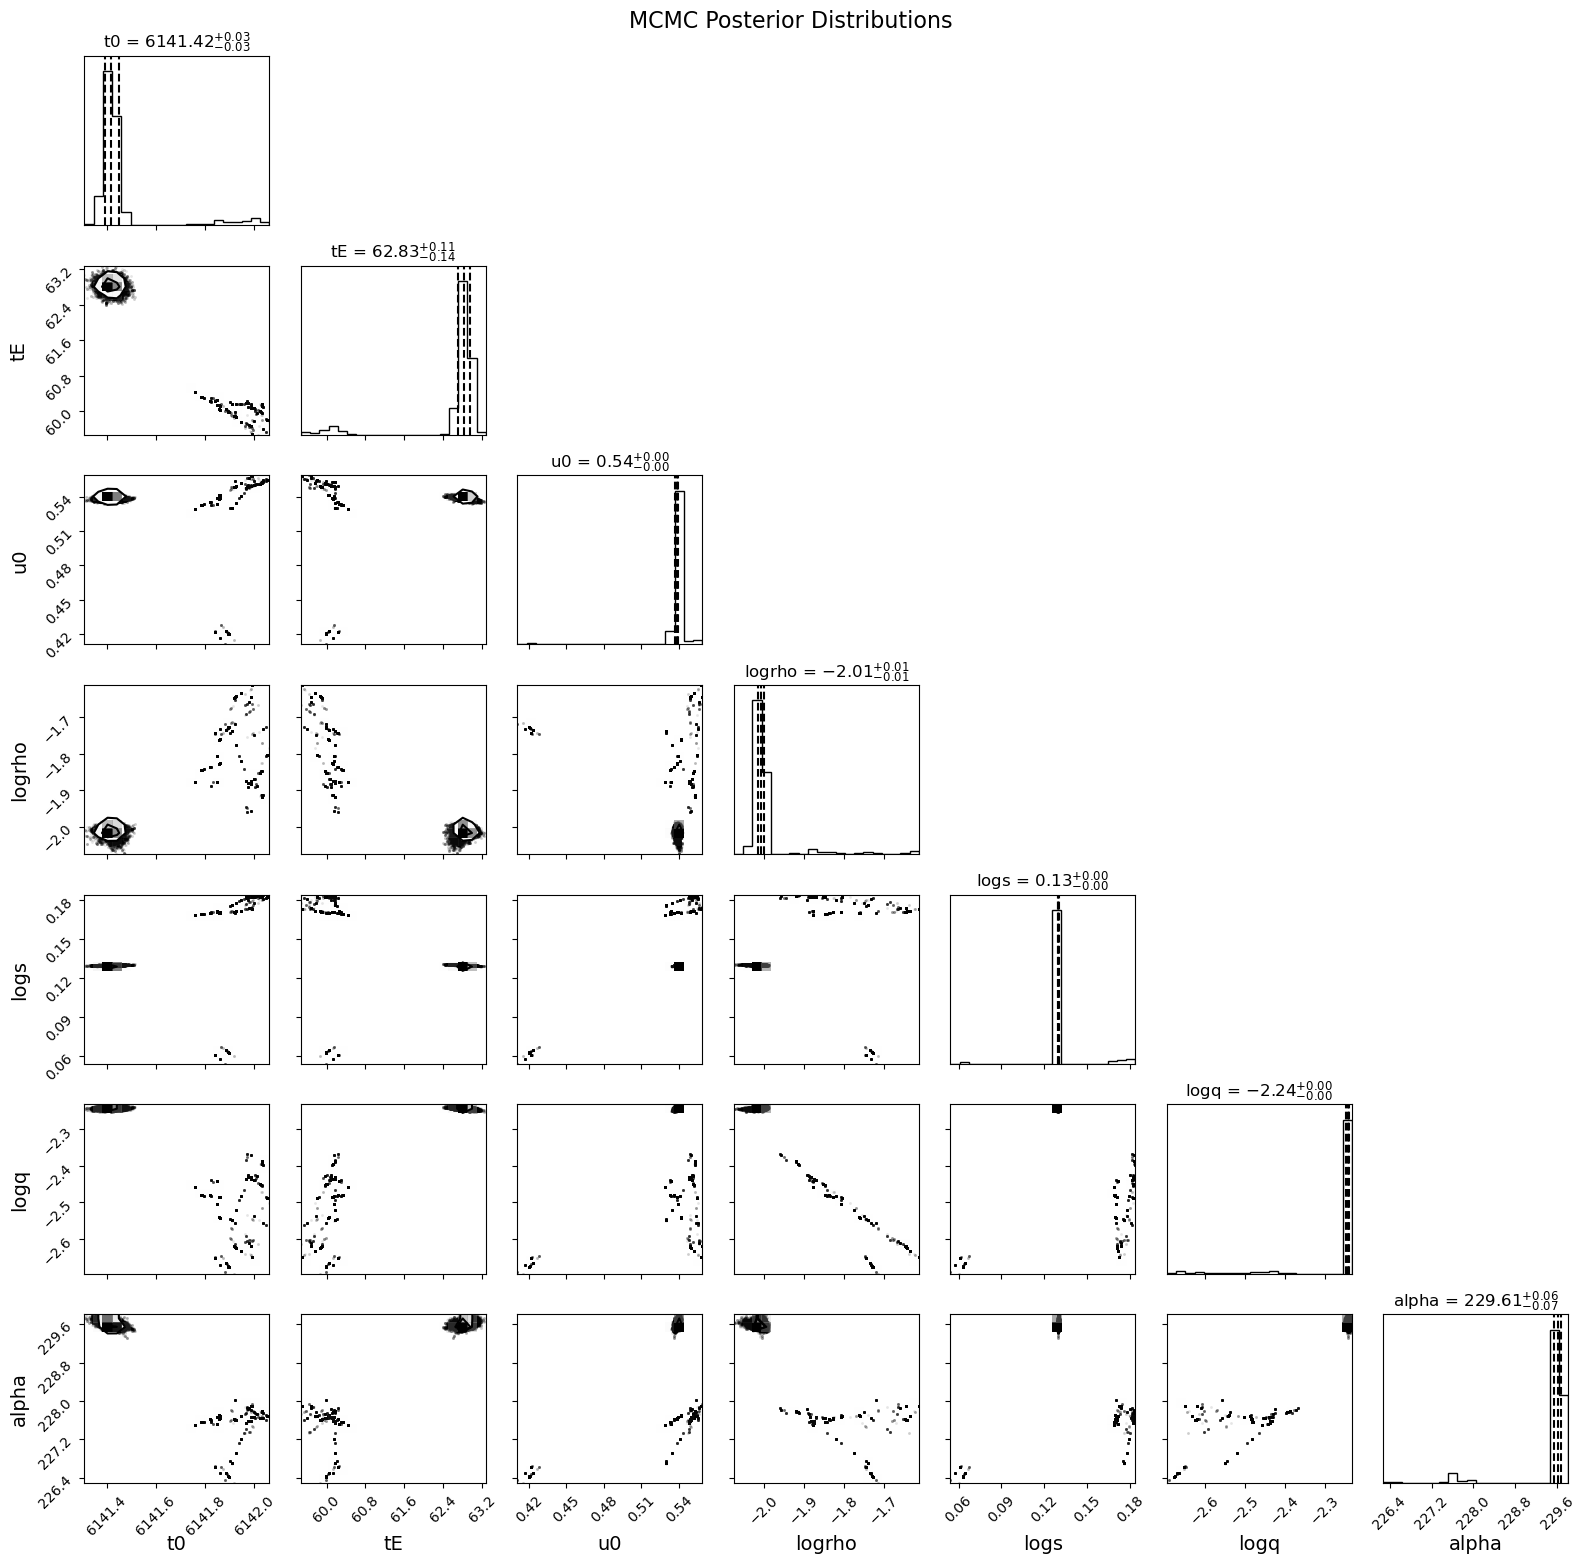

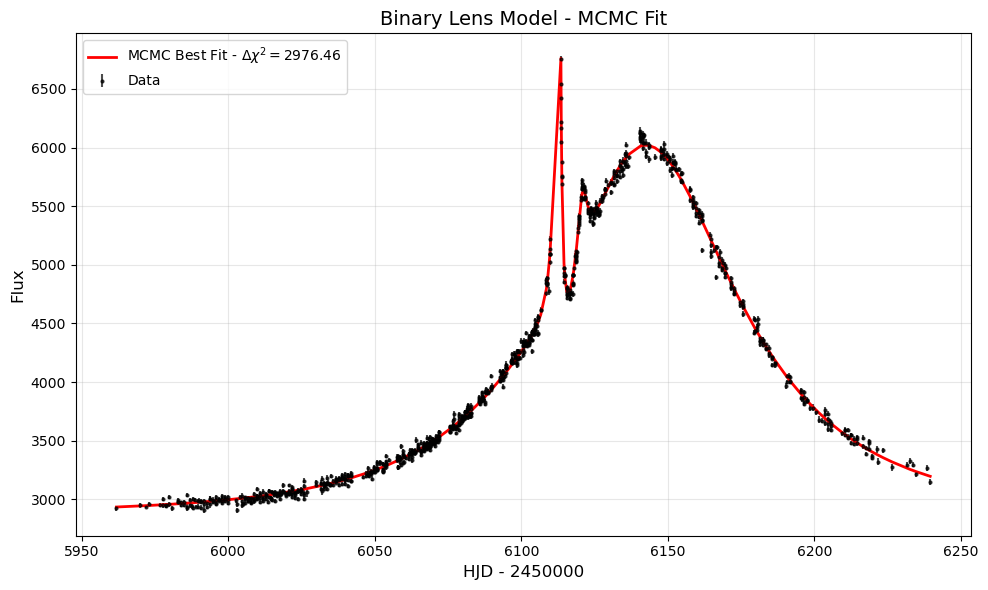

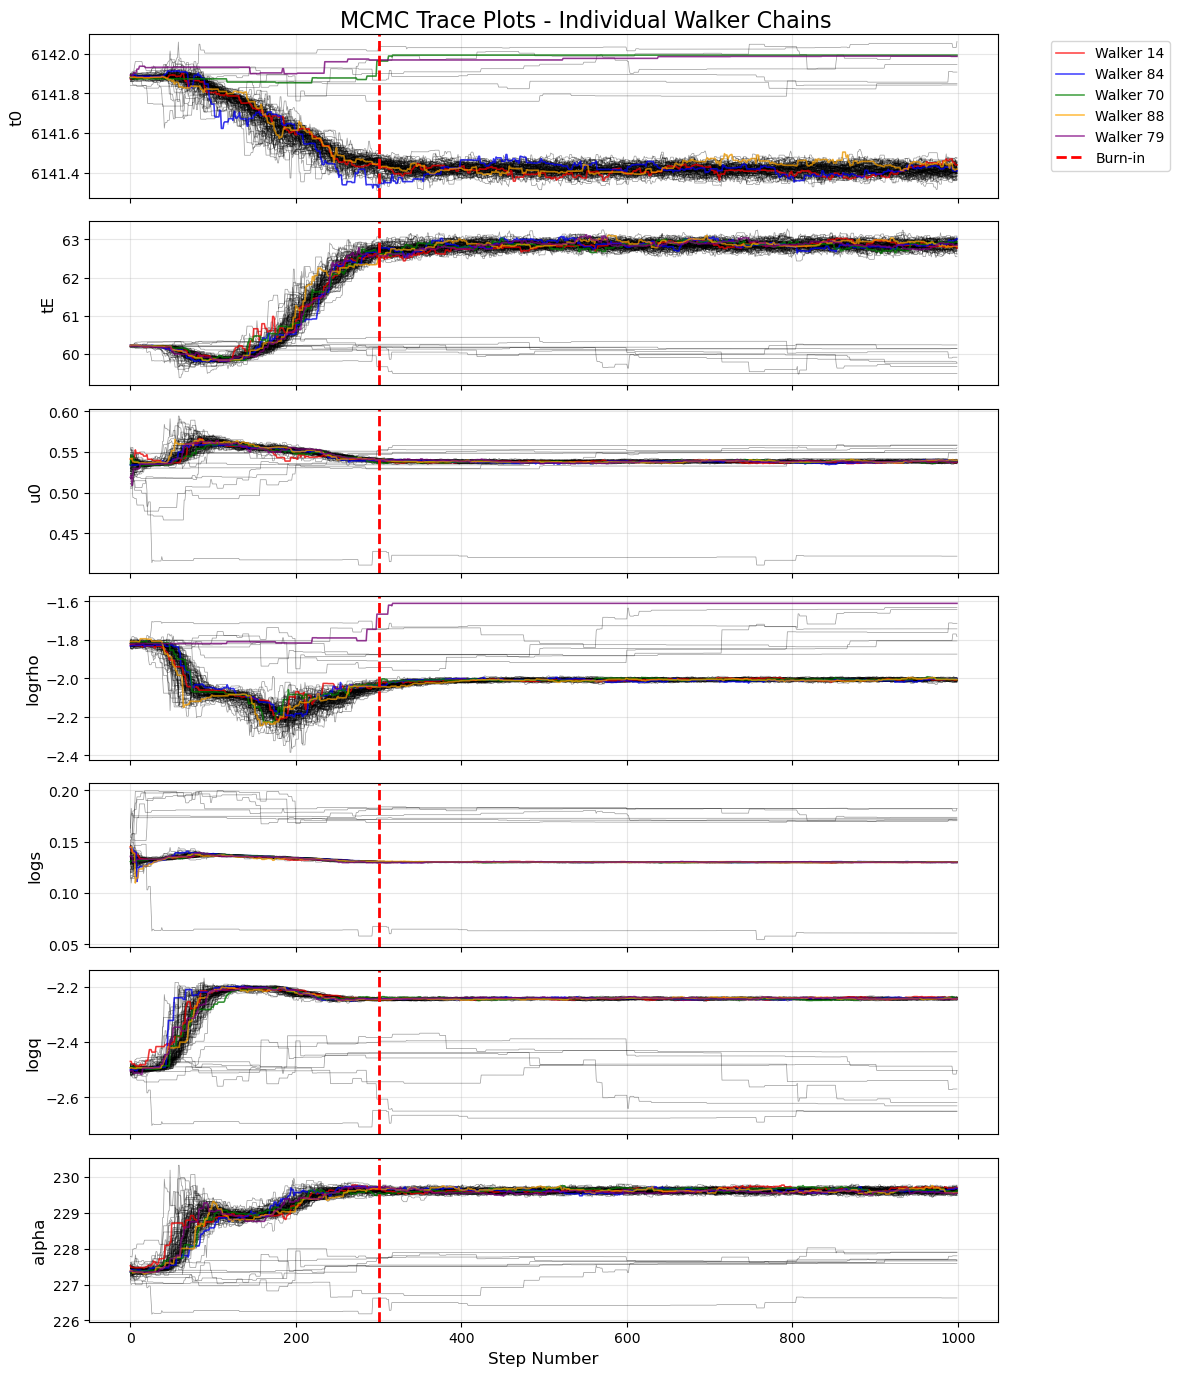

In [ ]:
#run MCMC on the best solution to find final refined solution

x0 = np.array([results['sorted_results'][0]['all_params']['t0'], results['sorted_results'][0]['all_params']['tE'], results['sorted_results'][0]['all_params']['u0'], results['sorted_results'][0]['all_params']['logrho'], results['sorted_results'][0]['all_params']['logs'], results['sorted_results'][0]['all_params']['logq'], results['sorted_results'][0]['all_params']['alpha']])
p = ['t0', 'tE', 'u0', 'logrho', 'logs', 'logq', 'alpha']

# Choose bounds to restrict the search to the vicinity of the best solution
grid_mcmc1 = micro_mc(df, x0, p, log_probability, bounds={'u0': (u0i - 2, u0i + 2), 'logrho': (-5, -0.5), 't0': (t0i - tEi, t0i + tEi), 'tE': (tEi - 20, tEi + 20), 'logs': (0.0, 0.2), 'logq': (-3.5, -1), 'alpha': (results['sorted_results'][0]['all_params']['alpha']-20, results['sorted_results'][0]['all_params']['alpha']+20)})

#Run MCMC analysis with all plots enabled
results_final = grid_mcmc1.perform_mcmc_analysis(steps=1000, walkers=100, param_scales=np.array([1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-1]),
                               verbose=False, plot_corner=True, plot_fit=True, 
                               plot_traces=True, plot_convergence=False)


The MLE solution is a fairly good fit to the light curve! The posteriors can be improved by running longer chains with more walkers, and further restricting the phase space in which they search for solutions. 

Optimizations

Degeneracies

Higher order effects

Modelling tools